In [80]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read data

In [81]:
site = "Mahurangi"
results_dir = f"{site}-2024-03-22"

# Coweeta 2024-03-23
# Mahurangi 2024-03-22
home_dir = r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\analysis"
input_dir = os.path.join(home_dir, "3_GLUE_prerun", "results", results_dir)
output_dir = os.path.join(home_dir, "3_GLUE_prerun", "results", "GLUE_pre",results_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

senario_names = ['KGE on Flow', 'KGE on Soil Moisture', 'KGE on seasonal transition', 'KGE on Flow + KGE on Soil Moisture', 'KGE on Flow + Seasonal Timing on Soil Moisture']
senario_short_names = ['Reference', 'None', 'None', 'SM magnitude', 'SM timings']

In [82]:
df = pd.read_csv(os.path.join(input_dir, 'evaluation_metrics.csv'), index_col=0)
df_param = pd.read_csv(os.path.join(input_dir, 'prior_parameters.csv'), index_col=0)
df.head()
df['bias_in_seasonsig_dates_max'] = df[['SeasonTrans of Soil dry2wet_start','SeasonTrans of Soil dry2wet_end','SeasonTrans of Soil wet2dry_start','SeasonTrans of Soil wet2dry_end']].max(axis='columns')
# results_tot_metrics

In [83]:
df.columns

Index(['NSE on Flow', 'NSE on Soil', 'KGE on Flow', 'KGE on Soil',
       'SeasonTrans of Soil dry2wet_start', 'SeasonTrans of Soil dry2wet_end',
       'SeasonTrans of Soil wet2dry_start', 'SeasonTrans of Soil wet2dry_end',
       'SeasonTrans of Soil dry2wet_start_raw',
       'SeasonTrans of Soil dry2wet_end_raw',
       'SeasonTrans of Soil wet2dry_start_raw',
       'SeasonTrans of Soil wet2dry_end_raw', 'bias_in_seasonsig_dates_max'],
      dtype='object')

In [84]:
df = df_param.join(df,on="run_id")

# Check how many runs were behavioral

In [85]:
def is_behavioral(value, criteria, comparison_type):
    if comparison_type == 'greater':
        return value > criteria
    elif comparison_type == 'less':
        return value < criteria

# ... similarly define for other metrics
criteria_dict = {
    'KGE on Flow': {'criteria': 0.5, 'comparison_type': 'greater'},
    'KGE on Soil': {'criteria': 0.5, 'comparison_type': 'greater'},
    'SeasonTrans of Soil dry2wet_start': {'criteria': 30, 'comparison_type': 'less'},
    'SeasonTrans of Soil dry2wet_end': {'criteria': 30, 'comparison_type': 'less'},
    'SeasonTrans of Soil wet2dry_start': {'criteria': 30, 'comparison_type': 'less'},
    'SeasonTrans of Soil wet2dry_end': {'criteria': 30, 'comparison_type': 'less'},
    'bias_in_seasonsig_dates_max': {'criteria': 30, 'comparison_type': 'less'}
    # Add other columns and their criteria here
}

# Apply these criteria to create new columns
for column, info in criteria_dict.items():
    criteria = info['criteria']
    comparison_type = info['comparison_type']
    new_column_name = f'{column}_Behavioral'
    df[new_column_name] = df[column].apply(lambda x: is_behavioral(x, criteria, comparison_type))
    # Print the count of 'True' values for each new column
    true_count = df[new_column_name].sum()
    print(f"Number of behavioral runs {column}: {true_count}")

Number of behavioral runs KGE on Flow: 91324
Number of behavioral runs KGE on Soil: 61166
Number of behavioral runs SeasonTrans of Soil dry2wet_start: 99996
Number of behavioral runs SeasonTrans of Soil dry2wet_end: 54586
Number of behavioral runs SeasonTrans of Soil wet2dry_start: 99996
Number of behavioral runs SeasonTrans of Soil wet2dry_end: 56126
Number of behavioral runs bias_in_seasonsig_dates_max: 30743


In [86]:
true_count = ((df['KGE on Soil_Behavioral'] == True) & (df['KGE on Flow_Behavioral'] == True)).sum()
print(f"Number of behavioral runs both KGE Flow & SM: {true_count}")


Number of behavioral runs both KGE Flow & SM: 61063


# Plot the intersection of two criteria

# Selected

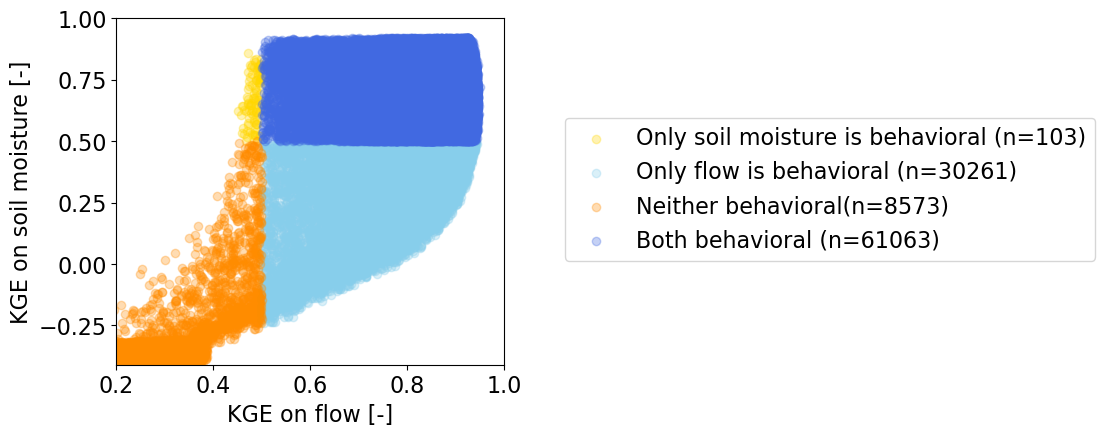

In [87]:
fig, ax =  plt.subplots(figsize=(5, 4.5))
x = df['KGE on Flow'].values
y = df['KGE on Soil'].values

# Use the new behavioral columns
x_behavioral = df['KGE on Flow_Behavioral'].values
y_behavioral = df[f'KGE on Soil_Behavioral'].values

x_and_y_behavioral = np.logical_and(x_behavioral, y_behavioral)
only_y_behavioral = np.logical_and(y_behavioral, np.logical_not(x_behavioral))
only_x_behavioral = np.logical_and(x_behavioral, np.logical_not(y_behavioral))
neither_behavioral = np.logical_not(np.logical_or(x_behavioral, y_behavioral))

# Plot each category with its respective color and label
plt.scatter(x[only_y_behavioral], y[only_y_behavioral], alpha=0.3, color='gold', label=f'Only soil moisture is behavioral (n={np.count_nonzero(only_y_behavioral)})')
plt.scatter(x[only_x_behavioral], y[only_x_behavioral], alpha=0.3, color='skyblue', label=f'Only flow is behavioral (n={np.count_nonzero(only_x_behavioral)})')
plt.scatter(x[neither_behavioral], y[neither_behavioral], alpha=0.3, color='darkorange', label=f'Neither behavioral(n={np.count_nonzero(neither_behavioral)})')
plt.scatter(x[x_and_y_behavioral], y[x_and_y_behavioral], alpha=0.3, color='royalblue', label=f'Both behavioral (n={np.count_nonzero(x_and_y_behavioral)})')

# Set labels, limits, title, and invert x-axis as in the original code
ax.set_xlabel('KGE on flow [-]')
ax.set_ylabel('KGE on soil moisture [-]')
ax.set_xlim([0.2, 1])
ax.set_ylim([-0.41, 1])

# Create a legend and save the figure
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.savefig(os.path.join(out_path, f'seasonsig_{seasonsig_var}.png'), bbox_inches='tight')



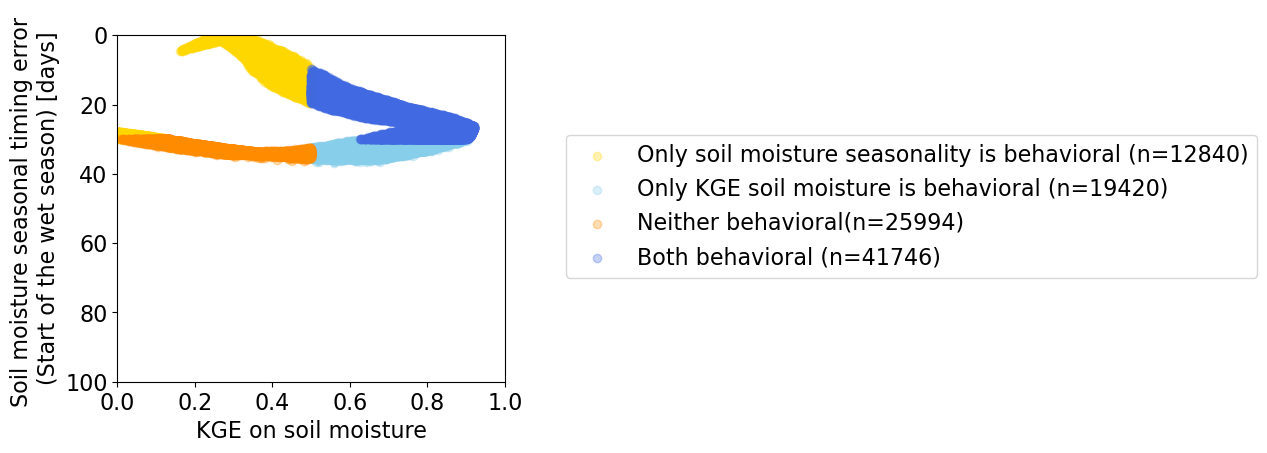

In [88]:

fig, ax =  plt.subplots(figsize=(5, 4.5))
x = df['KGE on Soil'].values
y = df['SeasonTrans of Soil dry2wet_end'].values

# Use the new behavioral columns
x_behavioral = df['KGE on Soil_Behavioral'].values
y_behavioral = df[f'SeasonTrans of Soil dry2wet_end_Behavioral'].values

x_and_y_behavioral = np.logical_and(x_behavioral, y_behavioral)
only_y_behavioral = np.logical_and(y_behavioral, np.logical_not(x_behavioral))
only_x_behavioral = np.logical_and(x_behavioral, np.logical_not(y_behavioral))
neither_behavioral = np.logical_not(np.logical_or(x_behavioral, y_behavioral))

# Plot each category with its respective color and label
plt.scatter(x[only_y_behavioral], y[only_y_behavioral], alpha=0.3, color='gold', label=f'Only soil moisture seasonality is behavioral (n={np.count_nonzero(only_y_behavioral)})')
plt.scatter(x[only_x_behavioral], y[only_x_behavioral], alpha=0.3, color='skyblue', label=f'Only KGE soil moisture is behavioral (n={np.count_nonzero(only_x_behavioral)})')
plt.scatter(x[neither_behavioral], y[neither_behavioral], alpha=0.3, color='darkorange', label=f'Neither behavioral(n={np.count_nonzero(neither_behavioral)})')
plt.scatter(x[x_and_y_behavioral], y[x_and_y_behavioral], alpha=0.3, color='royalblue', label=f'Both behavioral (n={np.count_nonzero(x_and_y_behavioral)})')

# Set labels, limits, title, and invert x-axis as in the original code
ax.set_xlabel('KGE on soil moisture')
ax.set_ylabel('Soil moisture seasonal timing error \n(Start of the wet season) [days]')
ax.set_xlim([0, 1])
ax.set_ylim([0, 100])
# ax.set_ylabel('Mean absolute differences in transition dates [days]')
# ax.set_ylim([0, 60])
ax.invert_yaxis()

# Create a legend and save the figure
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.savefig(os.path.join(out_path, f'seasonsig_{seasonsig_var}.png'), bbox_inches='tight')

# plt.close(fig)  # Close the figure to avoid displaying it in a notebook environment


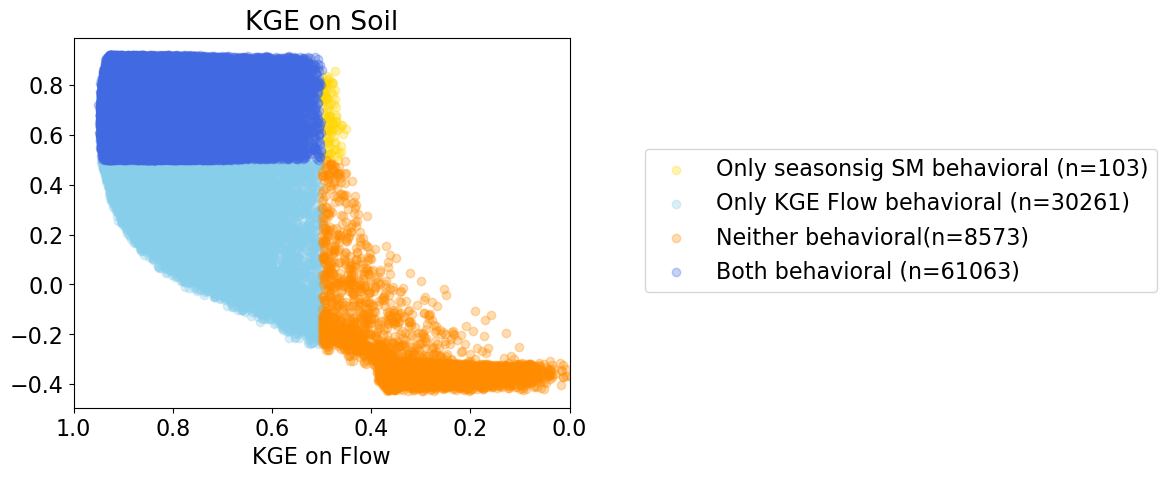

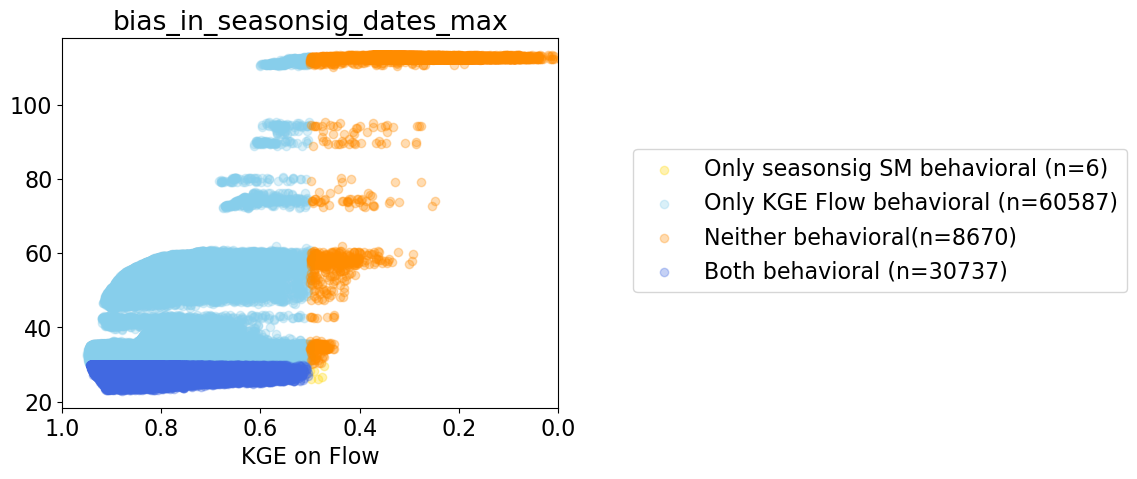

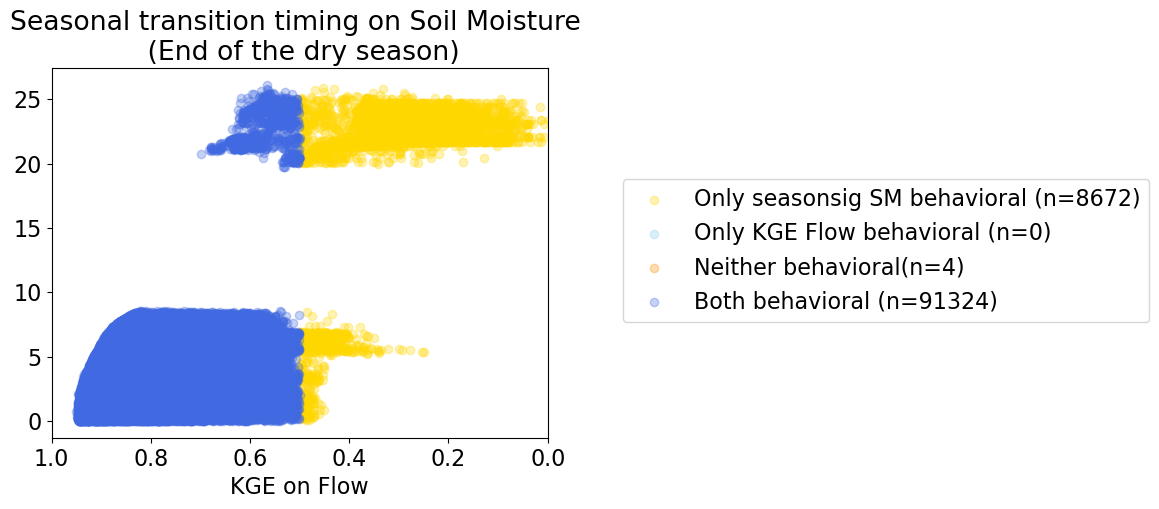

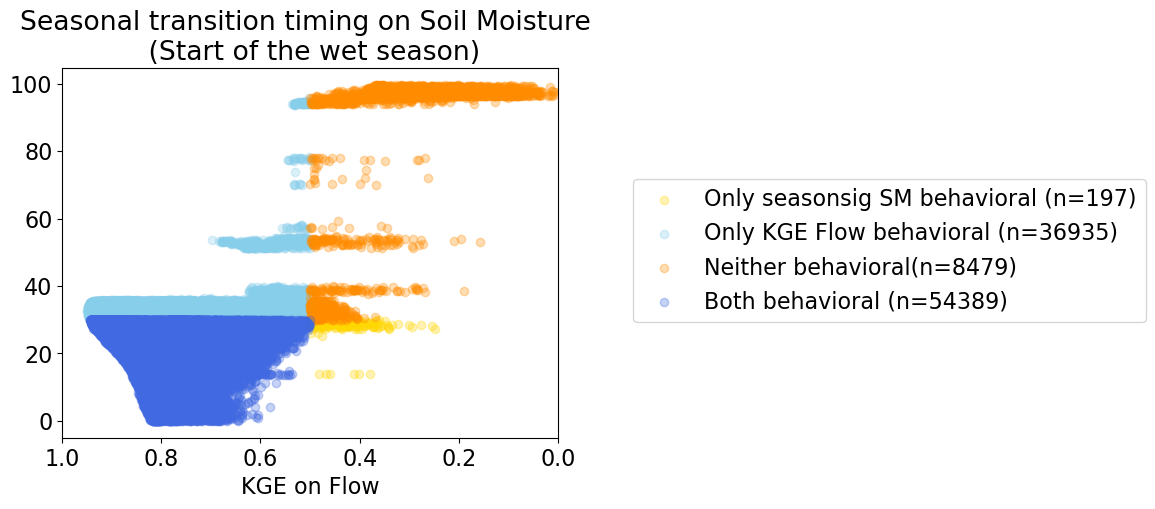

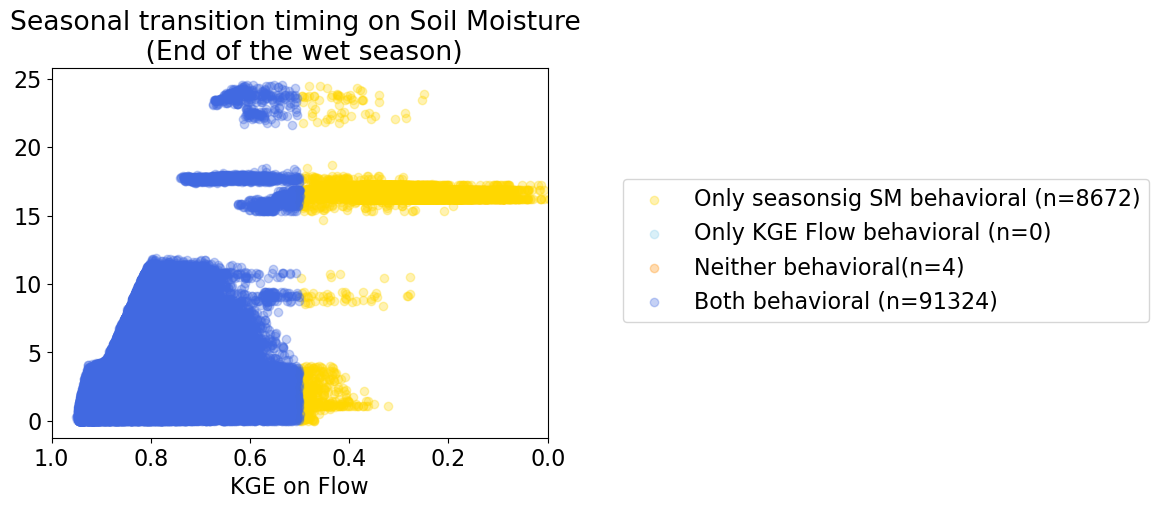

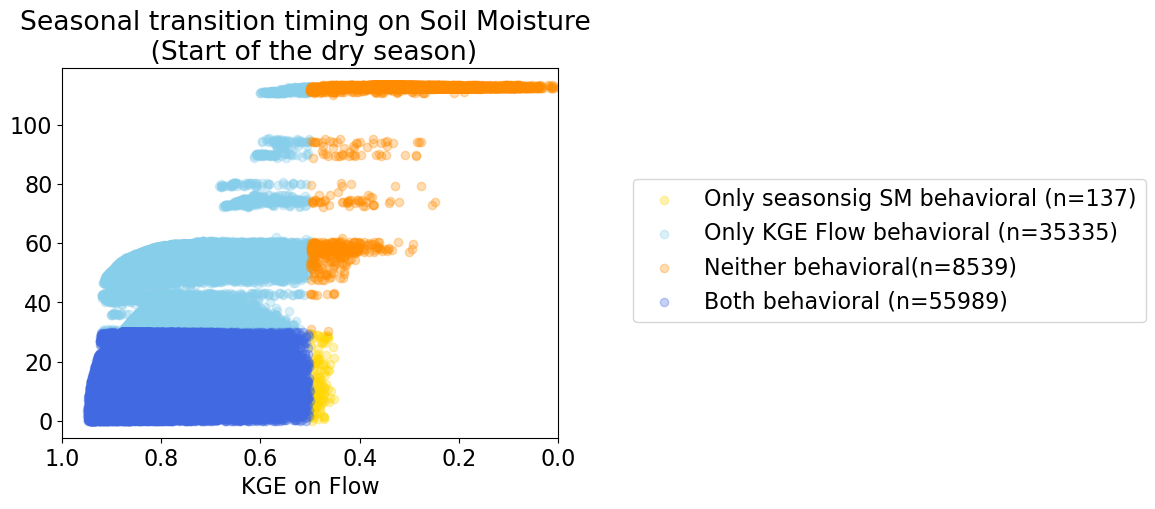

In [89]:

# Assuming results_tot_metrics is your new DataFrame with the _Behavioral columns added
# And out_path is defined as the directory where you want to save your figures

# Define your figure titles and variables as before
fig_titles = [
        'KGE on Soil',
    'bias_in_seasonsig_dates_max',
    'Seasonal transition timing on Soil Moisture \n (End of the dry season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (End of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the dry season)'
]

seasonsig_SM_vars = [
    'KGE on Soil',
    'bias_in_seasonsig_dates_max', 
    'SeasonTrans of Soil dry2wet_start', 
    'SeasonTrans of Soil dry2wet_end', 
    'SeasonTrans of Soil wet2dry_start', 
    'SeasonTrans of Soil wet2dry_end'
]

# Loop through your variables and create plots
for i, seasonsig_var in enumerate(seasonsig_SM_vars):
    fig, ax = plt.subplots()
    x = df['KGE on Flow'].values
    y = df[seasonsig_var].values
    
    # Use the new behavioral columns
    x_behavioral = df['KGE on Flow_Behavioral'].values
    y_behavioral = df[f'{seasonsig_var}_Behavioral'].values
    
    x_and_y_behavioral = np.logical_and(x_behavioral, y_behavioral)
    only_y_behavioral = np.logical_and(y_behavioral, np.logical_not(x_behavioral))
    only_x_behavioral = np.logical_and(x_behavioral, np.logical_not(y_behavioral))
    neither_behavioral = np.logical_not(np.logical_or(x_behavioral, y_behavioral))
    
    # Plot each category with its respective color and label
    plt.scatter(x[only_y_behavioral], y[only_y_behavioral], alpha=0.3, color='gold', label=f'Only seasonsig SM behavioral (n={np.count_nonzero(only_y_behavioral)})')
    plt.scatter(x[only_x_behavioral], y[only_x_behavioral], alpha=0.3, color='skyblue', label=f'Only KGE Flow behavioral (n={np.count_nonzero(only_x_behavioral)})')
    plt.scatter(x[neither_behavioral], y[neither_behavioral], alpha=0.3, color='darkorange', label=f'Neither behavioral(n={np.count_nonzero(neither_behavioral)})')
    plt.scatter(x[x_and_y_behavioral], y[x_and_y_behavioral], alpha=0.3, color='royalblue', label=f'Both behavioral (n={np.count_nonzero(x_and_y_behavioral)})')
    
    # Set labels, limits, title, and invert x-axis as in the original code
    ax.set_xlabel('KGE on Flow')
    ax.set_xlim([0, 1])
    # ax.set_ylabel('Mean absolute differences in transition dates [days]')
    # ax.set_ylim([0, 60])
    ax.set_title(fig_titles[i])
    ax.invert_xaxis()
    
    # Create a legend and save the figure
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # fig.savefig(os.path.join(out_path, f'seasonsig_{seasonsig_var}.png'), bbox_inches='tight')
    
    # plt.close(fig)  # Close the figure to avoid displaying it in a notebook environment


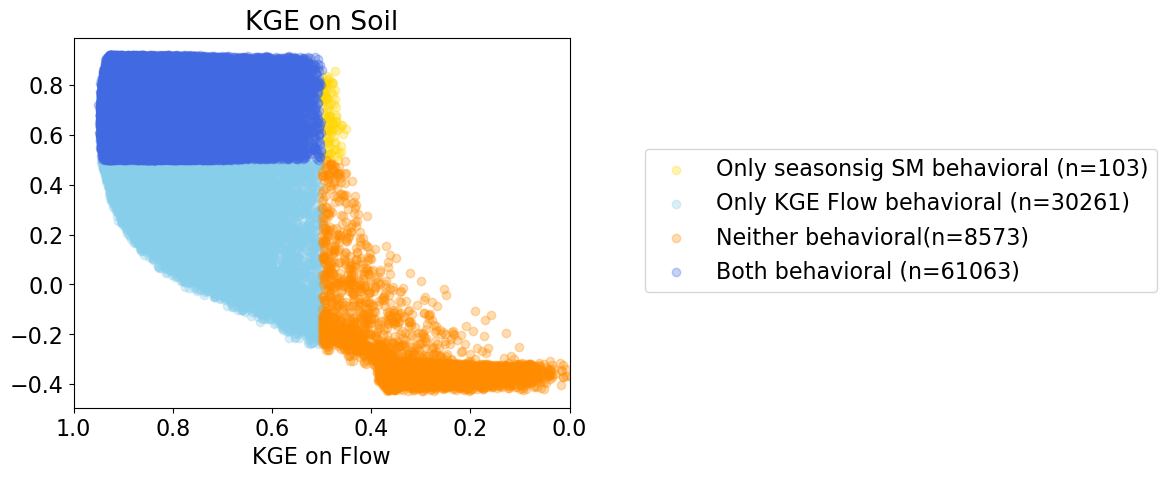

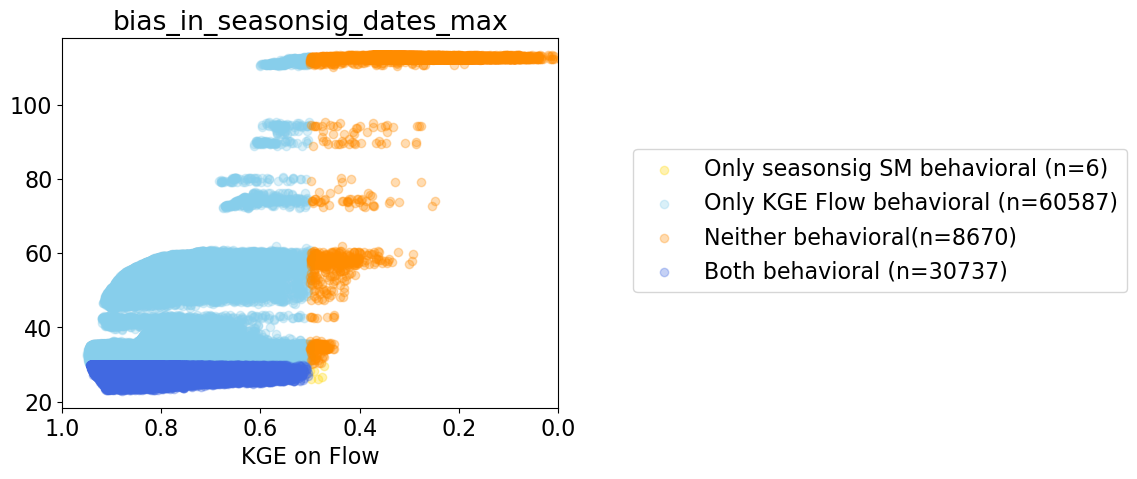

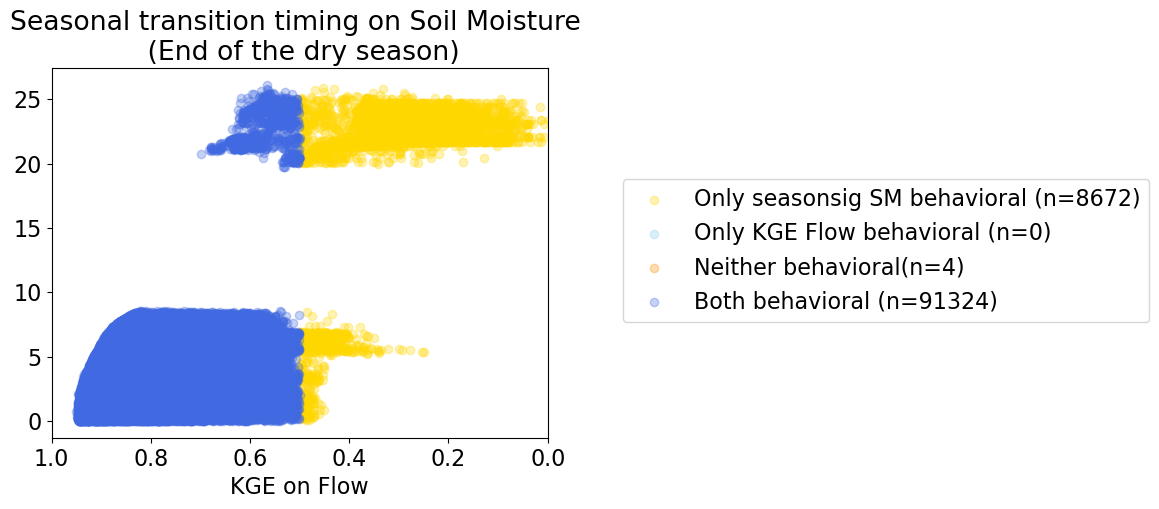

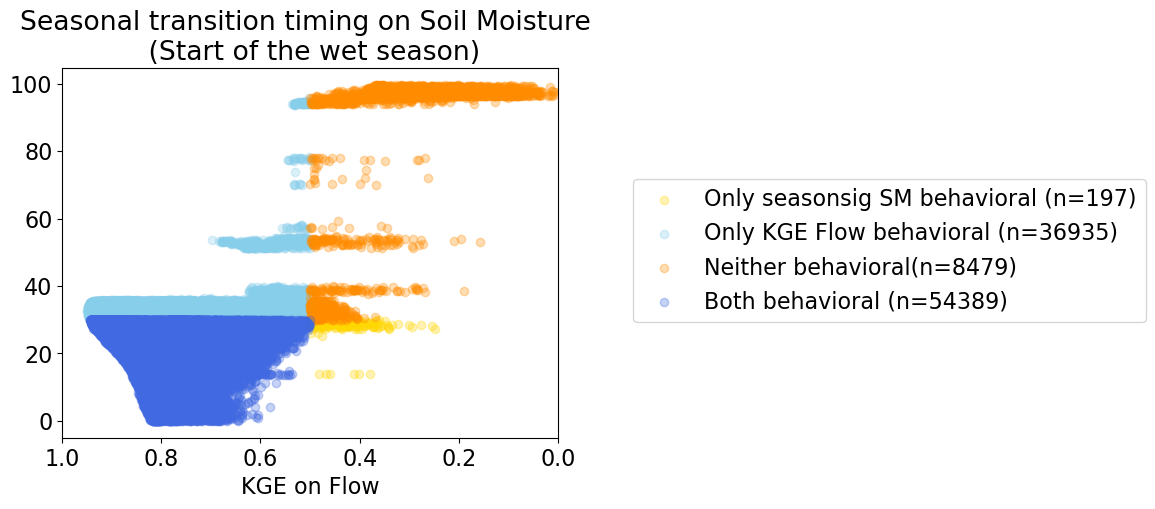

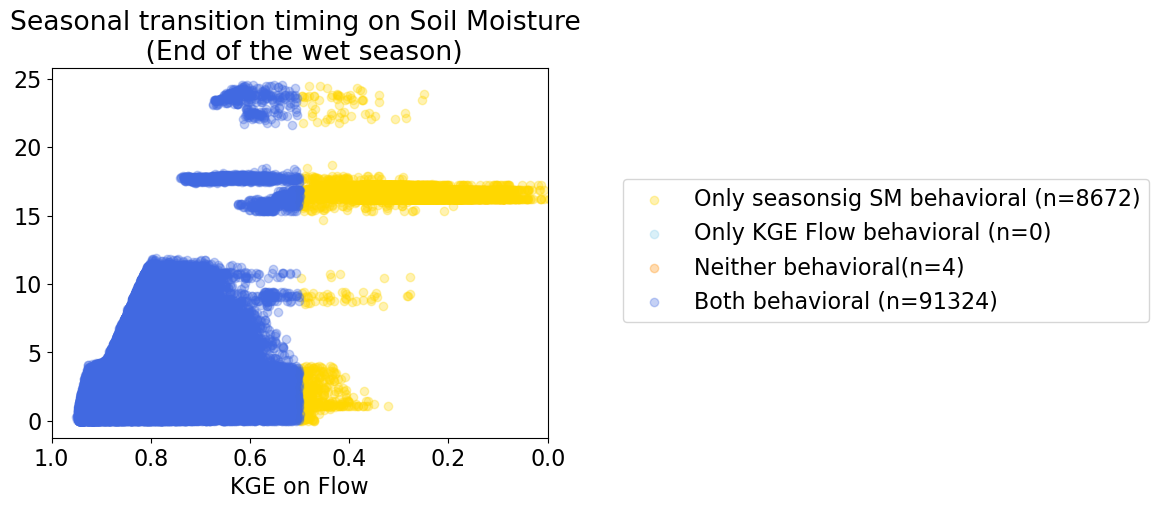

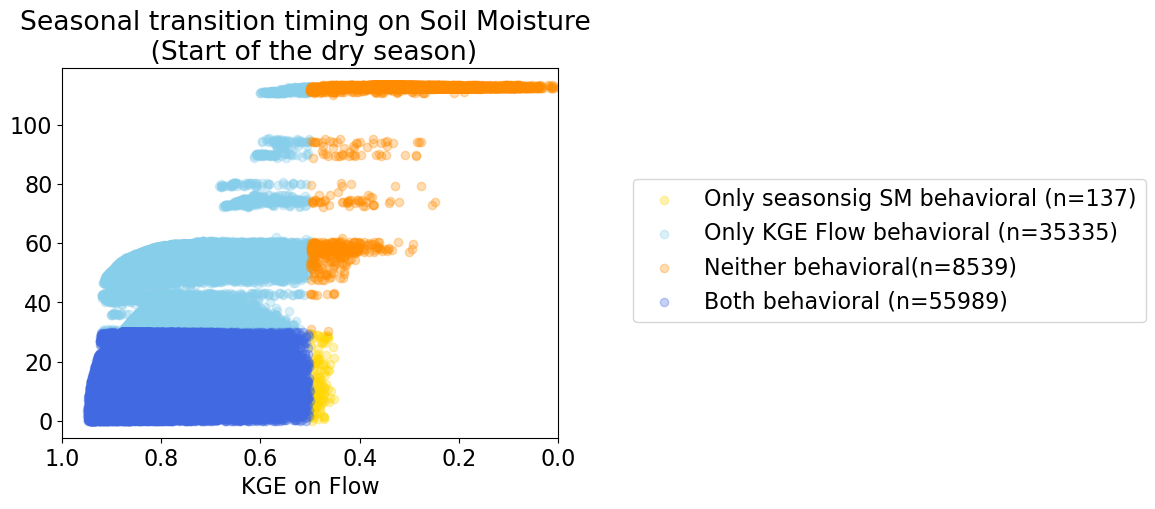

In [90]:

# Assuming results_tot_metrics is your new DataFrame with the _Behavioral columns added
# And out_path is defined as the directory where you want to save your figures

# Define your figure titles and variables as before
fig_titles = [
        'KGE on Soil',
    'bias_in_seasonsig_dates_max',
    'Seasonal transition timing on Soil Moisture \n (End of the dry season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (End of the wet season)', 
    'Seasonal transition timing on Soil Moisture \n (Start of the dry season)'
]

seasonsig_SM_vars = [
    'KGE on Soil',
    'bias_in_seasonsig_dates_max', 
    'SeasonTrans of Soil dry2wet_start', 
    'SeasonTrans of Soil dry2wet_end', 
    'SeasonTrans of Soil wet2dry_start', 
    'SeasonTrans of Soil wet2dry_end'
]

# Loop through your variables and create plots
for i, seasonsig_var in enumerate(seasonsig_SM_vars):
    fig, ax = plt.subplots()
    x = df['KGE on Flow'].values
    y = df[seasonsig_var].values
    
    # Use the new behavioral columns
    x_behavioral = df['KGE on Flow_Behavioral'].values
    y_behavioral = df[f'{seasonsig_var}_Behavioral'].values
    
    x_and_y_behavioral = np.logical_and(x_behavioral, y_behavioral)
    only_y_behavioral = np.logical_and(y_behavioral, np.logical_not(x_behavioral))
    only_x_behavioral = np.logical_and(x_behavioral, np.logical_not(y_behavioral))
    neither_behavioral = np.logical_not(np.logical_or(x_behavioral, y_behavioral))
    
    # Plot each category with its respective color and label
    plt.scatter(x[only_y_behavioral], y[only_y_behavioral], alpha=0.3, color='gold', label=f'Only seasonsig SM behavioral (n={np.count_nonzero(only_y_behavioral)})')
    plt.scatter(x[only_x_behavioral], y[only_x_behavioral], alpha=0.3, color='skyblue', label=f'Only KGE Flow behavioral (n={np.count_nonzero(only_x_behavioral)})')
    plt.scatter(x[neither_behavioral], y[neither_behavioral], alpha=0.3, color='darkorange', label=f'Neither behavioral(n={np.count_nonzero(neither_behavioral)})')
    plt.scatter(x[x_and_y_behavioral], y[x_and_y_behavioral], alpha=0.3, color='royalblue', label=f'Both behavioral (n={np.count_nonzero(x_and_y_behavioral)})')
    
    # Set labels, limits, title, and invert x-axis as in the original code
    ax.set_xlabel('KGE on Flow')
    ax.set_xlim([0, 1])
    # ax.set_ylabel('Mean absolute differences in transition dates [days]')
    # ax.set_ylim([0, 60])
    ax.set_title(fig_titles[i])
    ax.invert_xaxis()
    
    # Create a legend and save the figure
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # fig.savefig(os.path.join(out_path, f'seasonsig_{seasonsig_var}.png'), bbox_inches='tight')
    
    # plt.close(fig)  # Close the figure to avoid displaying it in a notebook environment


# Get PDF of both metrics

In [91]:
df.head()

,bb,satdk,slop,smcmax,wltsmc,max_gw_storage,expon,NSE on Flow,NSE on Soil,KGE on Flow,...,SeasonTrans of Soil wet2dry_start_raw,SeasonTrans of Soil wet2dry_end_raw,bias_in_seasonsig_dates_max,KGE on Flow_Behavioral,KGE on Soil_Behavioral,SeasonTrans of Soil dry2wet_start_Behavioral,SeasonTrans of Soil dry2wet_end_Behavioral,SeasonTrans of Soil wet2dry_start_Behavioral,SeasonTrans of Soil wet2dry_end_Behavioral,bias_in_seasonsig_dates_max_Behavioral
run_id,,,,,,,,,,,,,,,,,,,,,
0,15.241602,0.003717,0.305407,0.511144,0.303985,0.143744,2.829918,0.870583,-0.116197,0.879833,...,"[3.553183412645012, 5.564178702421486, -9.3509...","[2.839305623434484, -7.19964348943904, -1.0057...",32.207192,True,True,True,False,True,True,False
1,9.591115,0.009610,0.288152,0.431847,0.337942,0.134378,4.848366,0.784071,-7.086928,0.335623,...,"[-24.075628217775375, -24.444016533903778, -3....","[-130.62747594481334, -97.83051315555349, -111...",113.377990,False,False,True,False,True,False,False
2,8.110328,0.003576,0.073707,0.564340,0.250904,0.166409,7.468712,0.742028,-1.650655,0.783288,...,"[3.6848616492934525, 4.674633755348623, -7.184...","[17.2484363601543, 1.0754332607612014, 7.55047...",30.647320,True,True,True,False,True,True,False
3,15.606284,0.008876,0.088979,0.540960,0.311782,0.158104,3.165957,0.869110,0.677258,0.873533,...,"[4.616347371600568, 5.564206396695226, -8.1339...","[7.981033302843571, -2.0500190486200154, 6.433...",30.500882,True,True,True,False,True,True,False
4,4.477468,0.005622,0.134352,0.402397,0.273392,0.175923,2.118343,0.754053,-26.885436,0.352326,...,"[-23.088874944485724, -23.444051386788487, -2....","[-129.64352019689977, -96.82443387899548, -110...",112.387019,False,False,True,False,True,False,False


In [92]:
df["senario_reference"] = df["KGE on Flow_Behavioral"]
df["senario_sm"] = df["KGE on Flow_Behavioral"] & df["KGE on Soil_Behavioral"]
df["senario_sm_timing"] = df["KGE on Flow_Behavioral"] & df["SeasonTrans of Soil dry2wet_start_Behavioral"] & df["SeasonTrans of Soil dry2wet_end_Behavioral"] & df["SeasonTrans of Soil wet2dry_start_Behavioral"] & df["SeasonTrans of Soil wet2dry_end_Behavioral"]

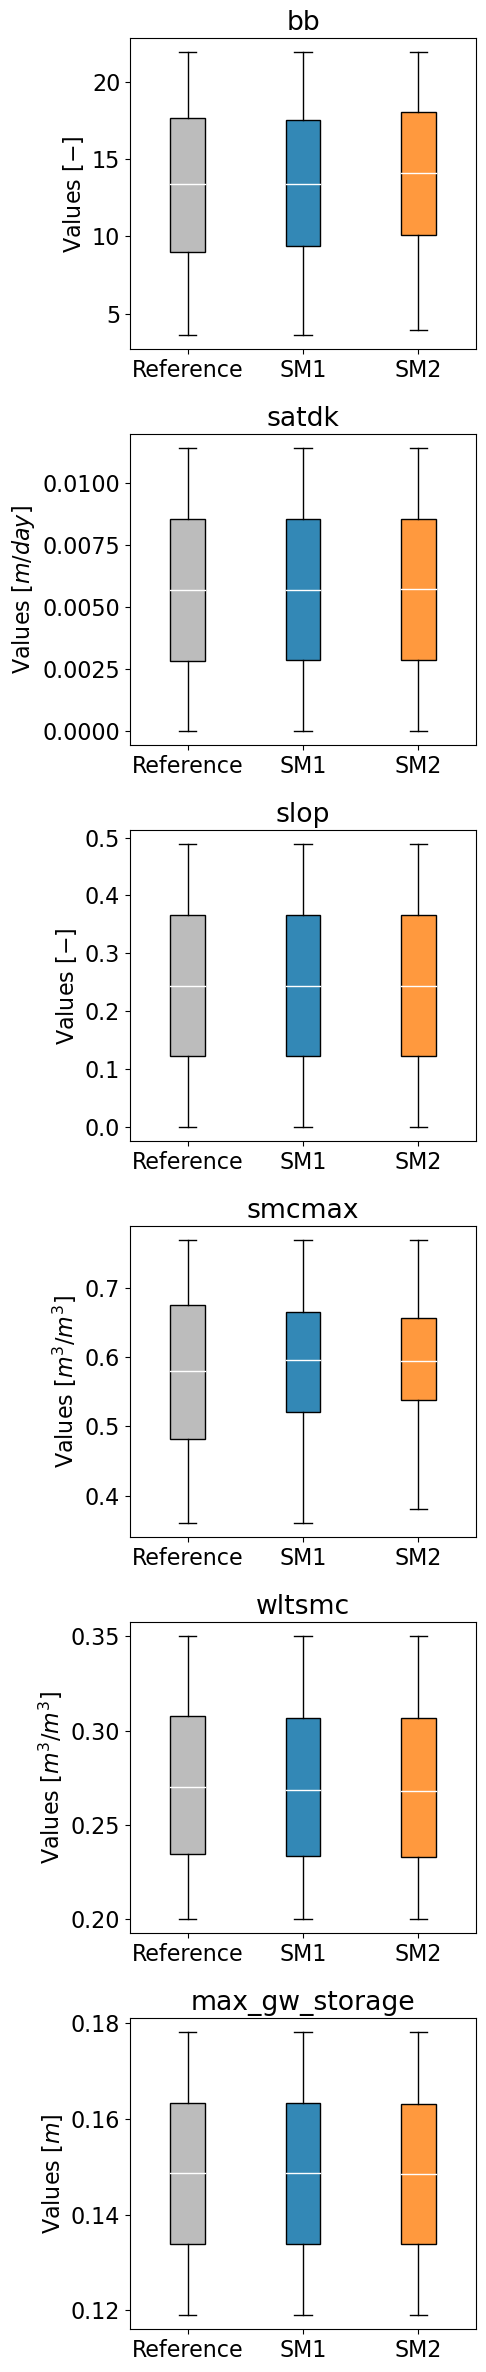

In [93]:
boxcolors = ["#bcbcbc", "#3388b6", "#ff993e"]
labels = ['Reference', 'SM1', 'SM2']
params = ['bb',	'satdk',	'slop'	,'smcmax'	,'wltsmc'	,'max_gw_storage']
param_unit = [r'$[-]$',	r'$[m/day]$',	r'$[-]$'	,r'$[m^3/m^3]$'	,r'$[m^3/m^3]$',r'$[m]$']
num_params = len(params)
fig, axs = plt.subplots(num_params, 1, figsize=(5, 4*num_params))

for i, param in enumerate(params): 
    param_senario_refs = df[param][df["senario_reference"]].values
    param_senario_sm = df[param][df["senario_sm"]].values
    param_senario_sm_timing = df[param][df["senario_sm_timing"]].values

    data = [param_senario_refs, param_senario_sm, param_senario_sm_timing]
    
    # Get the artists from the boxplot
    bp = axs[i].boxplot(data, labels=labels,  patch_artist=True)

    # Set facecolor for each box
    for patch, color in zip(bp['boxes'], boxcolors):
        patch.set_facecolor(color)
    
    for median in bp['medians']:
        median.set_color('white')
        
    axs[i].set_title(param)
    axs[i].set_ylabel(f'Values {param_unit[i]}')

fig.tight_layout()
output_fig_dir = r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\figs\parambox"
fig.savefig(os.path.join(output_fig_dir, f'parambox_{site}.pdf'), dpi=600, bbox_inches='tight')

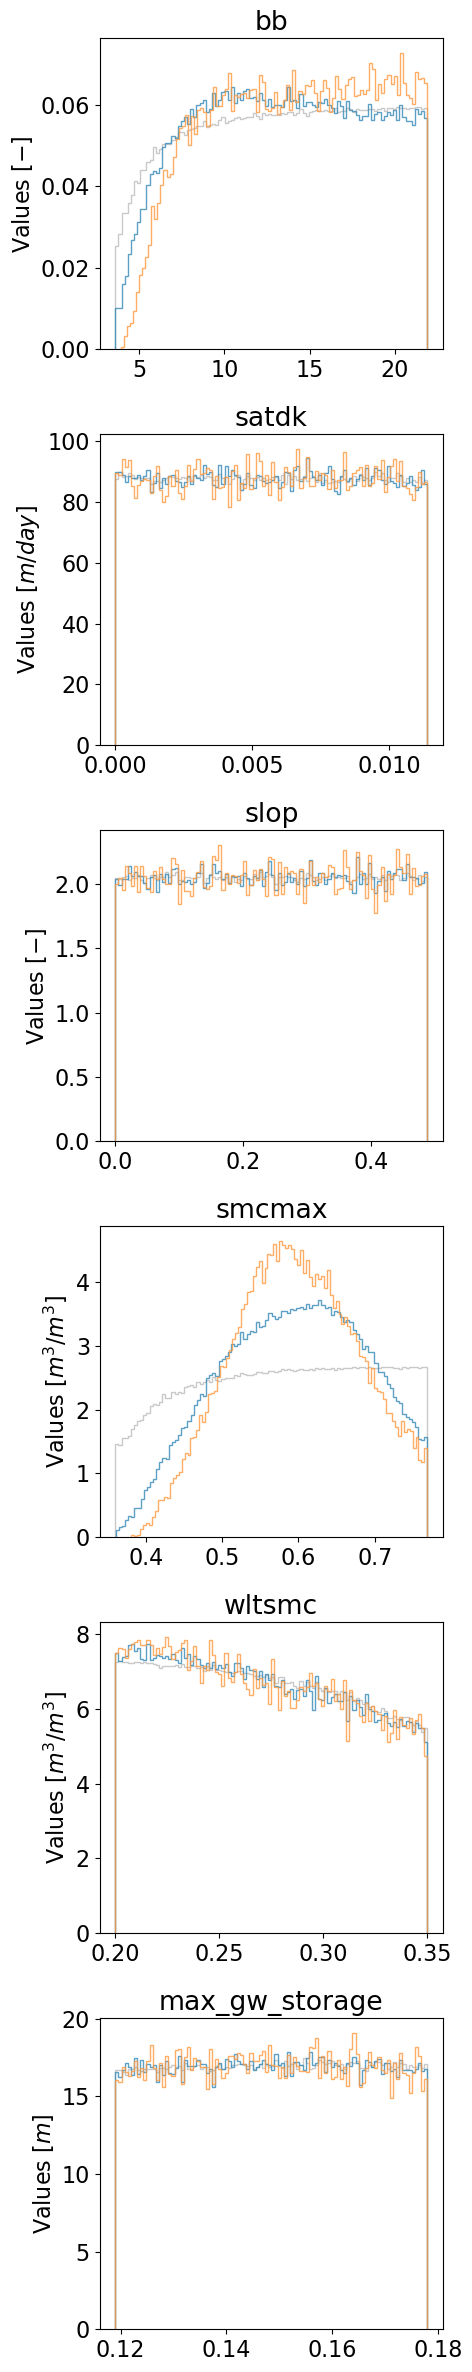

In [94]:
boxcolors = ["#bcbcbc", "#3388b6", "#ff993e"]
labels = ['Reference', 'SM1', 'SM2']
params = ['bb',	'satdk',	'slop'	,'smcmax'	,'wltsmc'	,'max_gw_storage']
param_unit = [r'$[-]$',	r'$[m/day]$',	r'$[-]$'	,r'$[m^3/m^3]$'	,r'$[m^3/m^3]$',r'$[m]$']
num_params = len(params)
fig, axs = plt.subplots(num_params, 1, figsize=(5, 4*num_params))

for i, param in enumerate(params): 
    param_senario_refs = df[param][df["senario_reference"]].values
    param_senario_sm = df[param][df["senario_sm"]].values
    param_senario_sm_timing = df[param][df["senario_sm_timing"]].values

    data = [param_senario_refs, param_senario_sm, param_senario_sm_timing]
    
    # Get the artists from the boxplot
    # Plot kernel density estimate for each scenario
    bins = 100
    alpha= 0.8
    axs[i].hist(param_senario_refs, density=True, bins=bins, alpha=alpha,  histtype='step',label='Reference', color='#bcbcbc')
    axs[i].hist(param_senario_sm, density=True, bins=bins, alpha=alpha, histtype='step', label='SM1', color='#3388b6')
    axs[i].hist(param_senario_sm_timing, density=True, bins=bins, alpha=alpha, histtype='step', label='SM2', color='#ff993e')
    

    # Set facecolor for each box
    for patch, color in zip(bp['boxes'], boxcolors):
        patch.set_facecolor(color)
    
    for median in bp['medians']:
        median.set_color('white')
        
    axs[i].set_title(param)
    axs[i].set_ylabel(f'Values {param_unit[i]}')

fig.tight_layout()
output_fig_dir = r"G:\Shared drives\Ryoko and Hilary\SMSigxModel\figs\parambox"
fig.savefig(os.path.join(output_fig_dir, f'paramhist_{site}.pdf'), dpi=600, bbox_inches='tight')

# Check the KGE-SM distribution

In [95]:
df.head()

,bb,satdk,slop,smcmax,wltsmc,max_gw_storage,expon,NSE on Flow,NSE on Soil,KGE on Flow,...,KGE on Flow_Behavioral,KGE on Soil_Behavioral,SeasonTrans of Soil dry2wet_start_Behavioral,SeasonTrans of Soil dry2wet_end_Behavioral,SeasonTrans of Soil wet2dry_start_Behavioral,SeasonTrans of Soil wet2dry_end_Behavioral,bias_in_seasonsig_dates_max_Behavioral,senario_reference,senario_sm,senario_sm_timing
run_id,,,,,,,,,,,,,,,,,,,,,
0,15.241602,0.003717,0.305407,0.511144,0.303985,0.143744,2.829918,0.870583,-0.116197,0.879833,...,True,True,True,False,True,True,False,True,True,False
1,9.591115,0.009610,0.288152,0.431847,0.337942,0.134378,4.848366,0.784071,-7.086928,0.335623,...,False,False,True,False,True,False,False,False,False,False
2,8.110328,0.003576,0.073707,0.564340,0.250904,0.166409,7.468712,0.742028,-1.650655,0.783288,...,True,True,True,False,True,True,False,True,True,False
3,15.606284,0.008876,0.088979,0.540960,0.311782,0.158104,3.165957,0.869110,0.677258,0.873533,...,True,True,True,False,True,True,False,True,True,False
4,4.477468,0.005622,0.134352,0.402397,0.273392,0.175923,2.118343,0.754053,-26.885436,0.352326,...,False,False,True,False,True,False,False,False,False,False


Text(0, 0.5, 'Density')

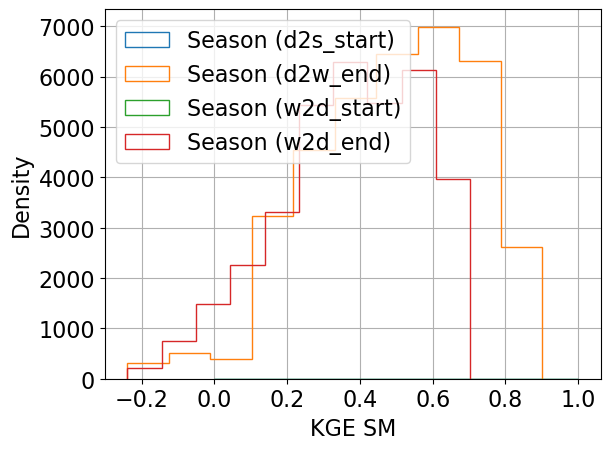

In [103]:
df2 = df["KGE on Soil"].replace([np.inf, -np.inf], np.nan)

# df2[df["senario_sm"]].hist(histtype='step', label="KGE SM")
# df2[df["senario_sm_timing"]].hist(histtype='step', label="Season (all)")
df2[df["senario_reference"] & ~df["SeasonTrans of Soil dry2wet_start_Behavioral"]].hist(histtype='step', label="Season (d2s_start)")
df2[df["senario_reference"] & ~df["SeasonTrans of Soil dry2wet_end_Behavioral"]].hist(histtype='step', label="Season (d2w_end)")
df2[df["senario_reference"] & ~df["SeasonTrans of Soil wet2dry_start_Behavioral"]].hist(histtype='step', label="Season (w2d_start)")
df2[df["senario_reference"] & ~df["SeasonTrans of Soil wet2dry_end_Behavioral"]].hist(histtype='step', label="Season (w2d_end)")

plt.legend(loc='upper left')
plt.xlabel("KGE SM")
plt.ylabel("Density")

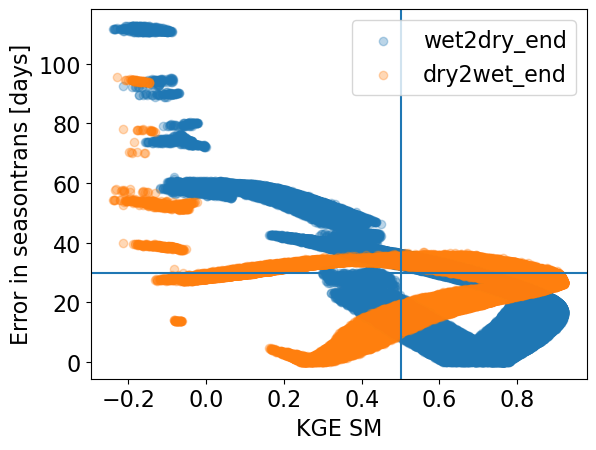

In [102]:
plt.scatter(df["KGE on Soil"][df["senario_reference"]], df["SeasonTrans of Soil wet2dry_end"][df["senario_reference"]], label="wet2dry_end", alpha=0.3)
plt.scatter(df["KGE on Soil"][df["senario_reference"]], df["SeasonTrans of Soil dry2wet_end"][df["senario_reference"]], label="dry2wet_end", alpha=0.3)
# plt.scatter(df["KGE on Soil"][df["senario_reference"]], df["SeasonTrans of Soil wet2dry_start"][df["senario_reference"]], label="wet2dry_start", alpha=0.3)
# plt.scatter(df["KGE on Soil"][df["senario_reference"]], df["SeasonTrans of Soil dry2wet_start"][df["senario_reference"]], label="dry2wet_start", alpha=0.3)
plt.axhline(y=30)
plt.axvline(x=0.5)
plt.xlabel("KGE SM")
plt.ylabel("Error in seasontrans [days]")
plt.legend()

# Get parmaeter distribution